#  Football Transfer Data Analysis

This project explores football transfer market data from 2013 to 2024. It includes transfer fees, market values, and the movement of players between clubs. The goal is to analyze trends, identify the most significant transfers, and explore clubs' spending patterns.

*   What is the relationship between a player's transfer fee and their estimated value?
*   Which clubs spend the most and which generate the most income through transfers?
*   How has total spending evolved during seasons?
*   Are there players who were "overvalued" or "undervalued"?
*   Which players have generated the most money in total transfers throughout their careers?
*   Are there any patterns in transfer spending before and after a major tournament (e.g., World Cup, Euro)?
*   How does a club's recent success (league titles, Champions League, etc.) influence its spending or earnings on player transfers?



# Data Preparation
This section includes importing necessary libraries, loading the dataset, and cleaning the data to prepare it for analysis.


## Imports

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading
The dataset is loaded from a CSV file, which contains details about football transfers, including fees, market values, and the clubs involved.


In [27]:
# Load the dataset containing football transfers
transfers_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Futbol/archive/transfers.csv', encoding='utf-8',on_bad_lines='skip', sep=",")

## Data Cleaning and Preparation
We convert transfer fees and market values to millions and parse transfer dates for time-based analysis.


In [28]:
# Convert transfer fee and market value from euros to millions
transfers_df['transfer_fee'] = transfers_df['transfer_fee'] / 1e6
transfers_df['market_value'] = transfers_df['market_value_in_eur'] / 1e6

# Convert the transfer date column to datetime format
transfers_df['transfer_date'] = pd.to_datetime(transfers_df['transfer_date'])

transfers_df['transfer_year'] = transfers_df['transfer_date'].dt.year
transfers_df = transfers_df[(transfers_df['transfer_year'] < 2025) & (transfers_df['transfer_year'] > 2012)]

# Remove not necessary columns
transfers_df = transfers_df.drop(['market_value_in_eur', 'player_id', 'to_club_id', 'from_club_id'], axis=1)


transfers_df['price_difference'] = transfers_df['market_value'] - transfers_df['transfer_fee']

# Exploratory Data Analysis (EDA)

## Distribution of Transfer Fees
The histogram below shows the distribution of the top 1000 most expensive transfers in the dataset.


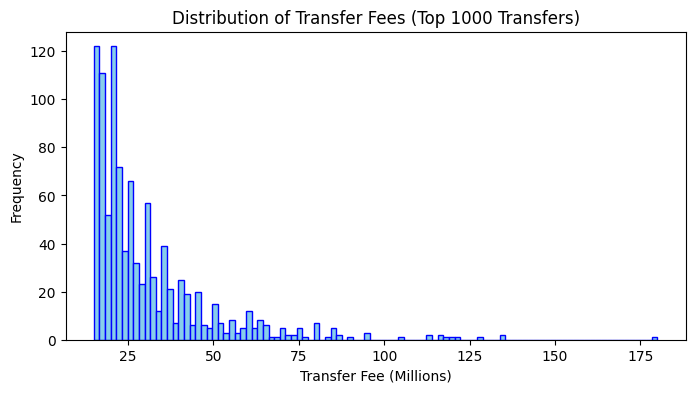

In [29]:
# Select the 1000 most expensive transfers for analysis
top_transfers_df = transfers_df.nlargest(1000, 'transfer_fee')

# Plot a histogram of transfer fees
plt.figure(figsize=(8, 4))
plt.hist(top_transfers_df['transfer_fee'], bins=100, color='skyblue', edgecolor='blue')
plt.xlabel('Transfer Fee (Millions)')
plt.ylabel('Frequency')
plt.title('Distribution of Transfer Fees (Top 1000 Transfers)')
plt.show()

## Top clubs with the most money moved in transfers

In [30]:
# Create a dataframe containing transfers info of each club
transfers_from = transfers_df.groupby('from_club_name').agg({'transfer_fee': 'sum', 'player_name': 'count'})
transfers_from = transfers_from.rename(columns={'transfer_fee': 'total_earned', 'player_name': 'transfers_out'})

transfers_to = transfers_df.groupby('to_club_name').agg({'transfer_fee': 'sum', 'player_name': 'count'})
transfers_to = transfers_to.rename(columns={'transfer_fee': 'total_spent', 'player_name': 'transfers_in'})
transfers_to['total_spent'] = -transfers_to['total_spent']

# Merge the two dataframes to get a combined view
club_transfers = pd.merge(transfers_from, transfers_to, left_index=True, right_index=True, how='outer')
club_transfers = club_transfers.fillna(0)

club_transfers['money_moved'] = club_transfers['total_earned'] + abs(club_transfers['total_spent'])
club_transfers.sort_values('money_moved', ascending=False).head()

,total_earned,transfers_out,total_spent,transfers_in,money_moved
Chelsea,909.90,188.0,-2359.40,218.0,3269.30
Man City,753.57,144.0,-1726.52,163.0,2480.09
Man Utd,474.49,127.0,-1837.67,144.0,2312.16
Juventus,901.42,169.0,-1222.30,195.0,2123.72
Barcelona,687.29,111.0,-1286.79,132.0,1974.08


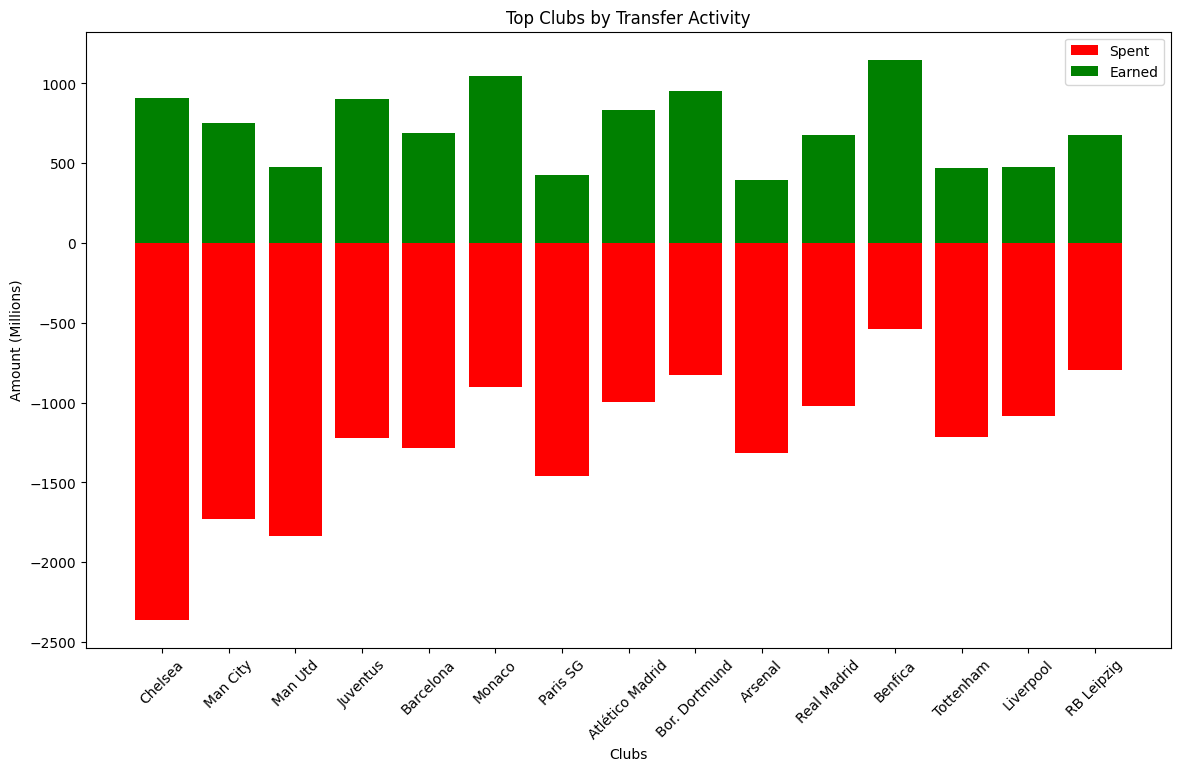

In [31]:
top_clubs = club_transfers.sort_values('money_moved', ascending=False).head(15)

# Bar plot comparing the total amount spent and earned by clubs
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(top_clubs.index, top_clubs['total_spent'], label='Spent', color='red')
ax.bar(top_clubs.index, top_clubs['total_earned'], label='Earned', color='green')
ax.set_xlabel('Clubs')
ax.set_ylabel('Amount (Millions)')
ax.set_title('Top Clubs by Transfer Activity')
ax.legend()
plt.xticks(rotation=45)
plt.show()

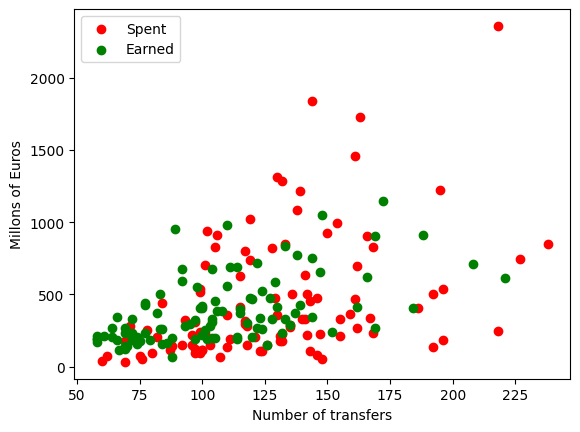

In [32]:
top_clubs = club_transfers.sort_values('money_moved', ascending=False).head(100)

plt.scatter(top_clubs['transfers_in'], -top_clubs['total_spent'], color='red')
plt.scatter(top_clubs['transfers_out'], top_clubs['total_earned'], color='green')

plt.xlabel('Number of transfers')
plt.ylabel('Millons of Euros')
plt.legend(['Spent','Earned'], loc='upper left')

## Number of transfers/total amount per Year

In [33]:
# Create a dataframe with the number of transfers and total amount of money spent each year
transfers_by_year = transfers_df.groupby('transfer_year').agg({
    'player_name': 'count',
    'transfer_fee': 'sum'
})
transfers_by_year = transfers_by_year.rename(columns={'player_name': 'transfer_count', 'transfer_fee': 'total_spent'})
transfers_by_year.head()

,transfer_count,total_spent
transfer_year,,
2013,2665,1389.9990
2014,3139,1427.4590
2015,3849,2174.2360
2016,4234,2669.6345
2017,5015,4137.3720


Text(0, 0.5, 'Number of transfers')

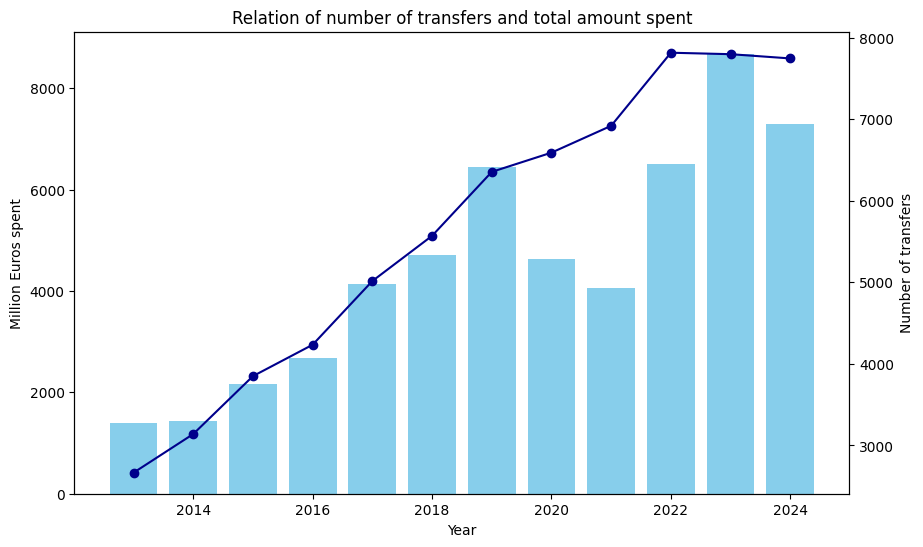

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(transfers_by_year.index, transfers_by_year['total_spent'], color='skyblue')
ax1.set_ylabel('Million Euros spent')
ax1.set_xlabel('Year')
ax1.title.set_text('Relation of number of transfers and total amount spent')

ax2 = ax1.twinx()

ax2.plot(transfers_by_year.index, transfers_by_year['transfer_count'], marker='o', color='darkblue')
ax2.set_ylabel('Number of transfers')

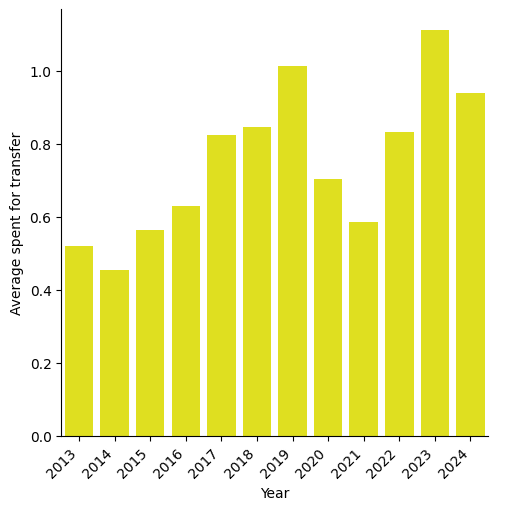

In [35]:
transfers_by_year['avg_spent_per_transfer'] = transfers_by_year['total_spent'] / transfers_by_year['transfer_count']

sns.catplot(data=transfers_by_year.reset_index(), x='transfer_year', y='avg_spent_per_transfer', kind='bar', color='yellow')
plt.xlabel('Year')
plt.ylabel('Average spent for transfer')
plt.xticks(rotation=45, ha='right')
plt.show()

## Number of transfers/total amount per Team

In [36]:
# Create a dataframe with the number of transfers and total amount of money spent for each team
transfers_by_team = transfers_df.groupby('to_club_name').agg({
    'player_name': 'count',
    'transfer_fee': 'sum'
})
transfers_by_team = transfers_by_team.rename(columns={'player_name': 'transfer_count', 'transfer_fee': 'total_spent'})
transfers_by_team = transfers_by_team.sort_values('total_spent', ascending=False).head(15)
transfers_by_team.head()

,transfer_count,total_spent
to_club_name,,
Chelsea,218,2359.40
Man Utd,144,1837.67
Man City,163,1726.52
Paris SG,161,1460.92
Arsenal,130,1315.13


<ipython-input-37-c9f0348396d9>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(transfers_by_team.index, rotation=45, ha='right')


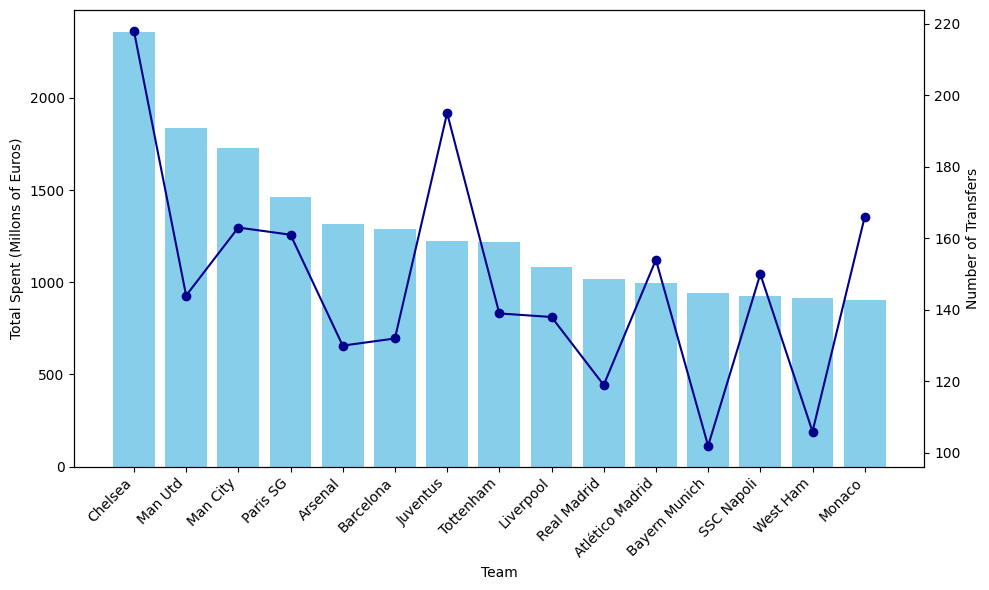

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(transfers_by_team.index, transfers_by_team['total_spent'], color='skyblue')
ax1.set_ylabel('Total Spent (Millons of Euros)')
ax1.set_xlabel('Team')

ax2 = ax1.twinx()
ax2.plot(transfers_by_team.index, transfers_by_team['transfer_count'], marker='o', color='darkblue')
ax2.set_ylabel('Number of Transfers')

ax1.set_xticklabels(transfers_by_team.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Study of the player's value/transfer fee

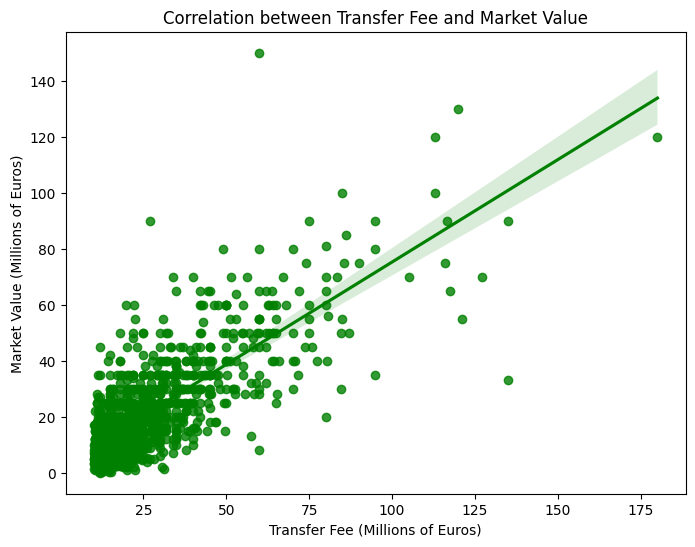

Correlation between Transfer Fee and Market Value: 0.7792220541233889


In [38]:
# First we remove the transfers without market value or free signings
paid_transfers_df = transfers_df[(transfers_df['transfer_fee'] > 10) & (transfers_df['market_value'] > 0)]

plt.figure(figsize=(8, 6))
sns.regplot(x='transfer_fee', y='market_value', data=paid_transfers_df, color='green')
plt.xlabel('Transfer Fee (Millions of Euros)')
plt.ylabel('Market Value (Millions of Euros)')
plt.title('Correlation between Transfer Fee and Market Value')
plt.show()

correlation = paid_transfers_df['transfer_fee'].corr(paid_transfers_df['market_value'])
print(f"Correlation between Transfer Fee and Market Value: {correlation}")

In [39]:
# Get the most overpaid and underpaid transfers
overpaids_df = paid_transfers_df.sort_values('price_difference',ascending=False).head(12)
underpaids_df = paid_transfers_df.sort_values('price_difference',ascending=True).head(12)

over_under_df = pd.concat([overpaids_df, underpaids_df])

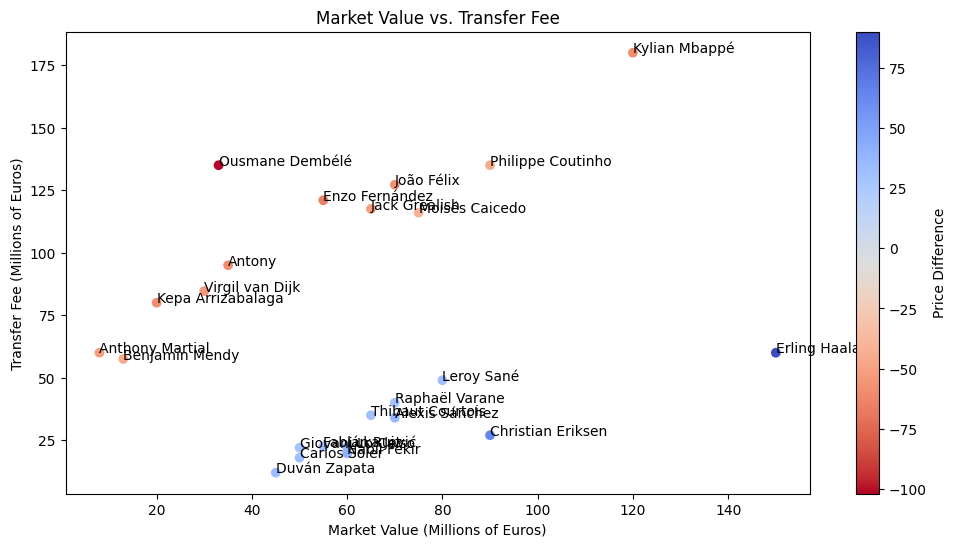

In [40]:
plt.figure(figsize=(12, 6))
plt.scatter(over_under_df['market_value'], over_under_df['transfer_fee'], c=over_under_df['price_difference'], cmap='coolwarm_r')
plt.xlabel('Market Value (Millions of Euros)')
plt.ylabel('Transfer Fee (Millions of Euros)')
plt.title('Market Value vs. Transfer Fee')
plt.colorbar(label='Price Difference')

# Player's name tags
for i, row in over_under_df.iterrows():
  plt.annotate(row['player_name'], (row['market_value'], row['transfer_fee']))

plt.show()

In [41]:
top_transfers_df = transfers_df.groupby(['player_name']).agg({'transfer_fee': 'sum', 'market_value':'count'}).reset_index()
top_transfers_df = top_transfers_df.rename(columns={'market_value': 'num_transfers', 'transfer_fee': 'total_money'})


top_transfers_df = top_transfers_df.sort_values('total_money', ascending=False).head(10)

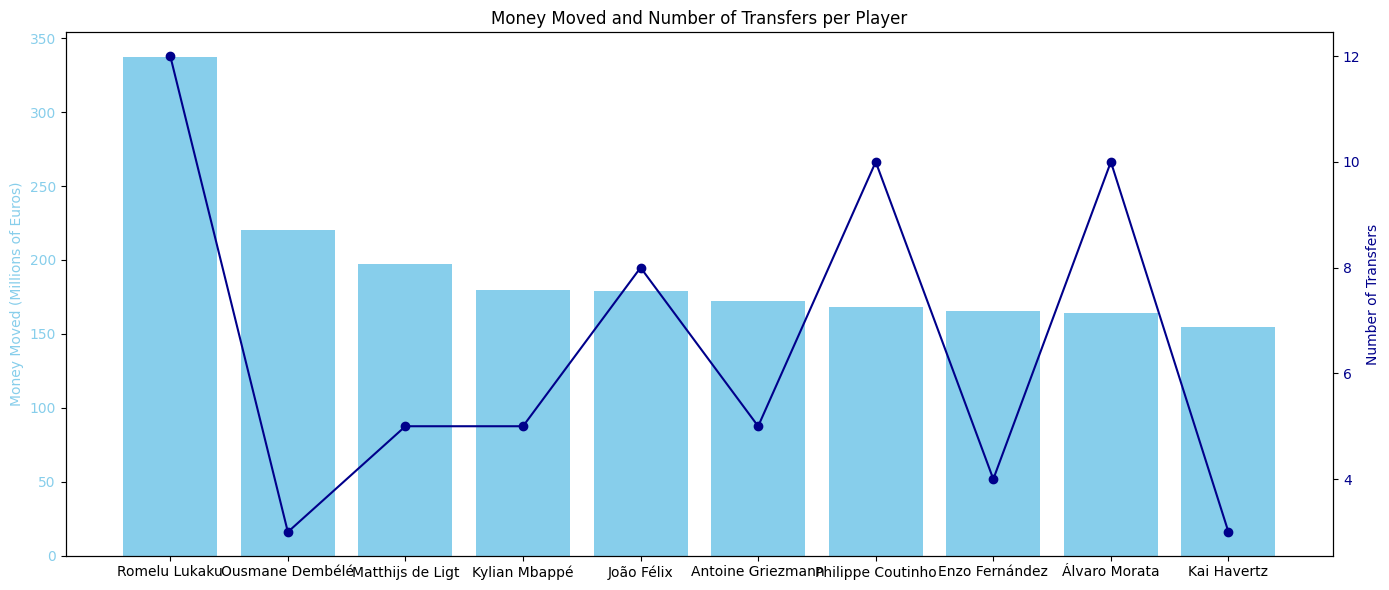

In [42]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart
ax1.bar(top_transfers_df['player_name'], top_transfers_df['total_money'], color='skyblue', label='Money Moved (Millions of Euros)')
ax1.set_ylabel('Money Moved (Millions of Euros)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Second Y-axis
ax2 = ax1.twinx()
ax2.plot(top_transfers_df['player_name'], top_transfers_df['num_transfers'], color='darkblue', marker='o', label='Number of Transfers')
ax2.set_ylabel('Number of Transfers', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Title and label adjustments
plt.title('Money Moved and Number of Transfers per Player')

# Rotate player names by 45 degrees
plt.xticks(rotation=45, ha='right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


## Total Spent by Each Team for Each Year

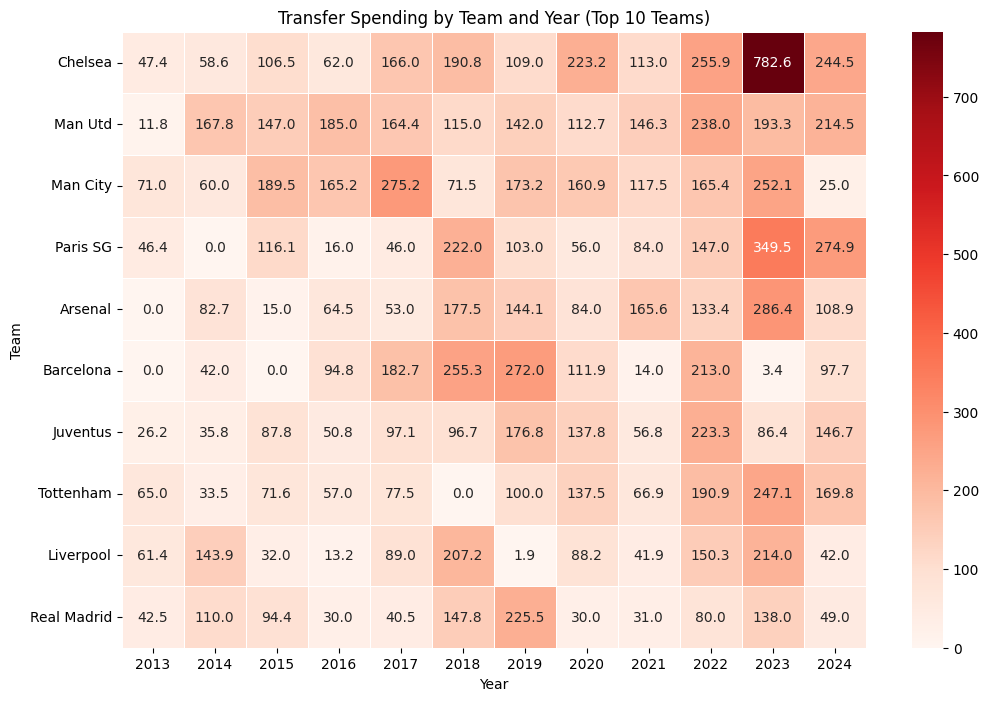

In [43]:
# Group by team and year, summing the transfer fees
transfers_by_team_year = transfers_df.groupby(['to_club_name', 'transfer_year'])['transfer_fee'].sum().unstack()

# Select the 10 teams with the highest total spending
top_spending_teams = transfers_by_team_year.sum(axis=1).nlargest(10).index

# Filter the DataFrame to include only the top 10 spending teams
transfers_by_team_year = transfers_by_team_year.loc[top_spending_teams]

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transfers_by_team_year, annot=True, fmt=".1f", cmap="Reds", linewidths=.5)
plt.title("Transfer Spending by Team and Year (Top 10 Teams)")
plt.xlabel("Year")
plt.ylabel("Team")
plt.show()

# Conclusion
This analysis revealed key insights into the football transfer market, including the most expensive transfers, top-earning clubs, and players who were over or undervalued compared to their market value.
